## CS235 Project Phase 1 - Vishal Rohith Chinnam, SID: 862466974

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


In [64]:
# Load the dataset
column_names = ['ID', 'Diagnosis'] + [f'{x}{y}' for x in ['Mean', 'SE', 'Worst'] for y in ['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', 'Concavity', 'ConcavePoints', 'Symmetry', 'FractalDimension']]
data = pd.read_csv('breast+cancer+wisconsin+diagnostic/wdbc.data', header=None, names=column_names)


In [65]:
# Convert Diagnosis column to numeric
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

# Separate features and labels
features = data.iloc[:, 2:]
labels = data['Diagnosis']


In [66]:
# Define stratified 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize scores
dt_scores, nb_scores = [], []


### 1. Implementing simple classifiers

#### Decision Tree Classifier:

Defined a class with methods to calculate entropy, information gain, and the best data split based on Information Gain.
Recursive method to build the decision tree based on the maximum information gain, up to a specified depth.
Predicts class labels for new data by traversing the decision tree according to feature thresholds until reaching a leaf node.
    
#### Naive Bayes Classifier:

Computes mean and standard deviation for each class in the training data, assuming Gaussian distributions for features.
Calculates class probabilities by combining prior probabilities with the Gaussian likelihood of the observed features. Classifies based on the highest probability.
    
#### Evaluation and Visualization:

Uses stratified 10-fold cross-validation to evaluate both models based on the F1 score.
Plots a bar chart comparing the F1 scores of the two classifiers, including error bars representing the standard deviation of the scores across cross-validation folds.

In [112]:
import numpy as np

# Decision Tree Classifier using the Information Gain as the criterion for splitting
class DecisionTreeClassifierIG:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth  # Maximum depth of the tree to prevent overfitting
        self.tree = None  # Initial tree is set to None

    # Method to calculate the entropy of a given dataset
    def entropy(self, y):
        unique, counts = np.unique(y, return_counts=True)  # Get unique labels and their frequency
        probs = counts / len(y)  # Calculate probabilities for each unique label
        return -np.sum(probs * np.log2(probs))  # Return the entropy of the dataset

    # Method to calculate information gain from a potential split
    def info_gain(self, y, y_left, y_right):
        parent_entropy = self.entropy(y)  # Calculate entropy of the parent set
        weight_left = len(y_left) / len(y)  # Proportion of examples in the left subset
        weight_right = len(y_right) / len(y)  # Proportion of examples in the right subset
        # Calculate and return the information gain
        return parent_entropy - (weight_left * self.entropy(y_left) + weight_right * self.entropy(y_right))

    def best_split(self, X, y):
        best_gain = -1
        best_split = None
        best_left, best_right = None, None
        for col in range(X.shape[1]):  # Iterate over each feature
            thresholds = np.unique(X[:, col]) # Get unique values as potential thresholds
            for threshold in thresholds:
                left_mask = X[:, col] <= threshold #<= threshold  # Create mask for left split
                right_mask = ~left_mask <= threshold  # Create mask for right split
                y_left, y_right = y[left_mask], y[right_mask]  # Split labels into left and right
                if len(y_left) > 0 and len(y_right) > 0:
                    gain = self.info_gain(y, y_left, y_right) # Calculate information gain
                    if gain > best_gain: # Check if this gain is the best so far
                        best_gain = gain
                        best_split = (col, threshold)
                        best_left, best_right = left_mask, right_mask
        if best_gain == -1:
            return None  # Ensure to return None if no valid split found
        return best_split[0], best_split[1], best_left, best_right  # Return tuple with all four elements

    # Recursive method to build the decision tree
    def build_tree(self, X, y, depth=0):
        # Return the most common label if stopping criteria met
        if len(set(y)) == 1 or depth == self.max_depth or len(y) < 2:
            return np.argmax(np.bincount(y))

        # Find the best split
        result = self.best_split(X, y)

        # Handle the case where no valid split was found
        if result is None:
            return np.argmax(np.bincount(y))

        # Unpack the result safely
        col, threshold, left_mask, right_mask = result

        # Construct a dictionary representing the decision node
        return {
            'feature': col,
            'threshold': threshold,
            'left': self.build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self.build_tree(X[right_mask], y[right_mask], depth + 1)
        }

    
    # Method to fit the model on the data
    def fit(self, X, y):
        y = y.astype(int)  # Ensure labels are integer
        self.tree = self.build_tree(X, y)  # Build the tree with the training data

    # Helper method to predict the label for a single instance
    def predict_one(self, node, x):
        if not isinstance(node, dict):
            return node  # Return the label if leaf node
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(node['left'], x)  # Go to left child
        else:
            return self.predict_one(node['right'], x)  # Go to right child

    # Method to predict the labels of a set of instances
    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)  # Convert input to numpy array if not already
            print("Converted X to numpy array.")
        if X.ndim != 2:
            raise ValueError("Input must be a 2D numpy array")
        return np.array([self.predict_one(self.tree, x) for x in X])  # Use predict_one for each instance


In [127]:
class GaussianNaiveBayesClassifier:
    def fit(self, X, y):
        self.classes = np.unique(y)  # Identify all unique classes in the data
        self.parameters = {}  # Initialize a dictionary to store the parameters for each class
        
        # Loop through each class to calculate and store its mean and standard deviation
        for c in self.classes:
            X_c = X[y == c]  # Extract samples belonging to class c
            self.parameters[c] = {
                'mean': X_c.mean(axis=0),  # Calculate mean for each feature of class c
                'std': X_c.std(axis=0)  # Calculate standard deviation for each feature of class c
            }

    def gaussian(self, x, mean, std):
        # Calculate the probability density of x for a normal distribution with given mean and std
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

    def predict(self, X):
        predictions = []  # Initialize a list to store predictions for each sample

        # Calculate the class probabilities for each sample in X
        for x in X:
            posteriors = []  # List to hold posterior probabilities of each class for a single sample
            
            # Compute the posterior probability for each class
            for c in self.classes:
                prior = np.mean(labels == c)  # Estimate the prior probability of class c
                # Calculate the likelihood by multiplying the Gaussian probabilities of all features
                likelihood = np.prod([self.gaussian(x[i], self.parameters[c]['mean'][i], self.parameters[c]['std'][i]) 
                                      for i in range(len(x))])
                posteriors.append(prior * likelihood)  # Multiply prior and likelihood and append to posteriors list
            
            # Select the class with the highest posterior probability
            predictions.append(np.argmax(posteriors))
        
        return np.array(predictions)  # Convert the list of predictions to a numpy array and return it


In [128]:
def evaluate_model(model, features, labels):
    scores = []  # Initialize a list to store the F1 scores for each fold
    
    # Loop over each train/test split generated by the StratifiedKFold object
    for train_index, test_index in skf.split(features, labels):
        # Select the training and testing data and labels using the indices provided by the split
        X_train, X_test = features.iloc[train_index].values, features.iloc[test_index].values
        y_train, y_test = labels.iloc[train_index].values, labels.iloc[test_index].values
        
        model.fit(X_train, y_train)  # Fit the model on the training data
        predictions = model.predict(X_test)  # Make predictions on the testing data
        
        # Calculate the F1 score for the current fold and append it to the scores list
        scores.append(f1_score(y_test, predictions))
    
    # Return the mean and standard deviation of the F1 scores across all folds
    return np.mean(scores), np.std(scores)

In [129]:
# Evaluate both classifiers
decision_tree = DecisionTreeClassifierIG(max_depth=5)
nb_classifier = GaussianNaiveBayesClassifier()

In [130]:
# Evaluate the Decision Tree classifier using stratified 10-fold cross-validation
# 'features' and 'labels' are the data sets used for training and validation
dt_mean, dt_std = evaluate_model(decision_tree, features, labels)

# Evaluate the Naive Bayes classifier using the same cross-validation method
nb_mean, nb_std = evaluate_model(nb_classifier, features, labels)


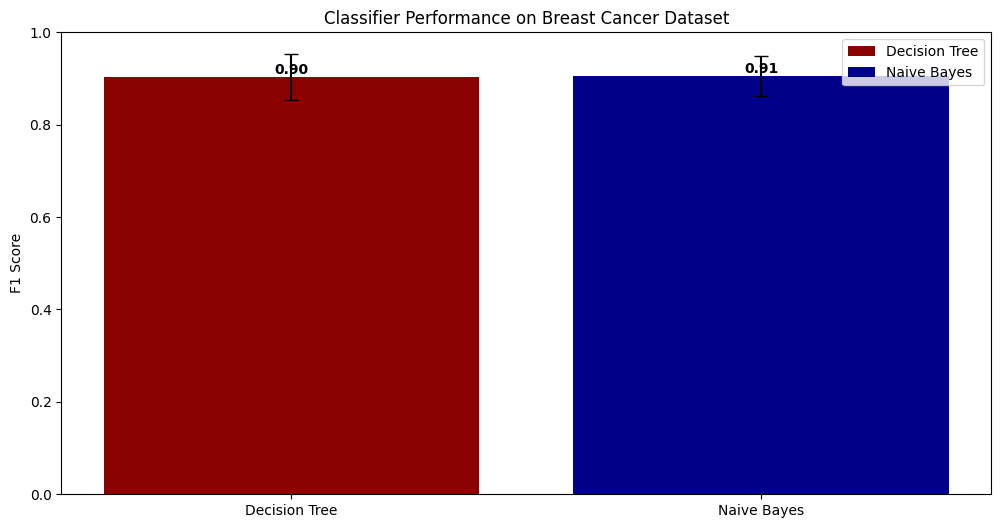

In [131]:
dt_scores.append(dt_mean)
nb_scores.append(nb_mean)

# Plot the results in a bar chart with a refreshed color scheme and other visual enhancements
plt.figure(figsize=(12, 6))
models = ['Decision Tree', 'Naive Bayes']
means = [dt_mean, nb_mean]
std_devs = [dt_std, nb_std]
colors = ['darkred', 'darkblue']  # Updated colors for each classifier

bars = plt.bar(models, means, yerr=std_devs, color=colors, capsize=5)
plt.ylabel('F1 Score')
plt.title('Classifier Performance on Breast Cancer Dataset')
plt.legend(bars, models)  # Updated legend to directly link to the bars

# Adding enhanced text labels for mean F1 scores on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold', color='black')

plt.show()

### 2. Dimensionality reduction with the Singular Value Decomposition

#### Data Preparation: 
Split the dataset into training and testing sets using train_test_split.

#### SVD Implementation:
Created a function apply_and_project_svd to apply SVD on the training data and project both the training and testing data onto spaces defined by top principal components.

#### Classifier Setup: 
Initialized two classifiers, a Decision Tree and a Gaussian Naive Bayes.

#### Dimensional Evaluation: 
Assessed classifier performance across different dimensions specified by n_components.

#### Performance Metrics: 
Measured performance using the F1 score for each classifier at each level of dimension reduction.

#### Visualization: 
Plotted F1 scores with error bars using matplotlib.pyplot to illustrate variability and trends.

#### Optimal Dimensions: 
Determined the optimal number of components for each classifier based on peak F1 scores.

In [156]:
from sklearn.model_selection import train_test_split

In [157]:
# # Splitting the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X = features.to_numpy()  # Convert features DataFrame to numpy array
y = labels.to_numpy()    # Convert labels Series to numpy array

In [158]:
# Function to apply SVD and project both training and testing data onto the new basis
def apply_and_project_svd(X_train, X_test, n_components):
    U, s, VT = np.linalg.svd(X_train, full_matrices=False)  # Perform SVD on the training data
    U_reduced = U[:, :n_components]  # Retain the first n_components of U
    S_reduced = np.diag(s[:n_components])  # Retain the first n_components of s as a diagonal matrix
    VT_reduced = VT[:n_components, :]  # Retain the first n_components of VT
    X_train_reduced = U_reduced @ S_reduced  # Project the training data onto the new basis
    X_test_reduced = X_test @ VT_reduced.T  # Project the test data onto the new basis
    return X_train_reduced, X_test_reduced

In [159]:
# Initialize the classifiers
decision_tree = DecisionTreeClassifierIG(max_depth=5)
nb_classifier = GaussianNaiveBayesClassifier()

In [160]:
# Define the list of ranks (number of dimensions) to evaluate
ranks = [10, 20, 50, 100, 200, 300]

# Lists to store F1 scores for each classifier across different ranks
f1_scores_dt = []
f1_scores_nb = []

In [162]:
# Loop through each rank
for rank in ranks:
    f1_dt_fold = []
    f1_nb_fold = []
    
    # Loop through each fold
    for train_index, test_index in skf.split(X, y):
        # Split data using the indices
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Reduce dimensionality
        X_train_reduced, X_test_reduced = apply_and_project_svd(X_train, X_test, rank)
        
        # Check and convert types if necessary
        if not isinstance(X_test_reduced, np.ndarray):
            X_test_reduced = np.array(X_test_reduced)

        # Fit classifiers
        decision_tree.fit(X_train_reduced, y_train)
        nb_classifier.fit(X_train_reduced, y_train)

        # Predict and evaluate
        dt_pred = decision_tree.predict(X_test_reduced)
        nb_pred = nb_classifier.predict(X_test_reduced)
        
        # Calculate F1 score for the current fold and rank
        f1_dt_fold.append(f1_score(y_test, dt_pred))
        f1_nb_fold.append(f1_score(y_test, nb_pred))
    
    # Store the mean F1 score for each rank
    f1_scores_dt.append(np.mean(f1_dt_fold))
    f1_scores_nb.append(np.mean(f1_nb_fold))

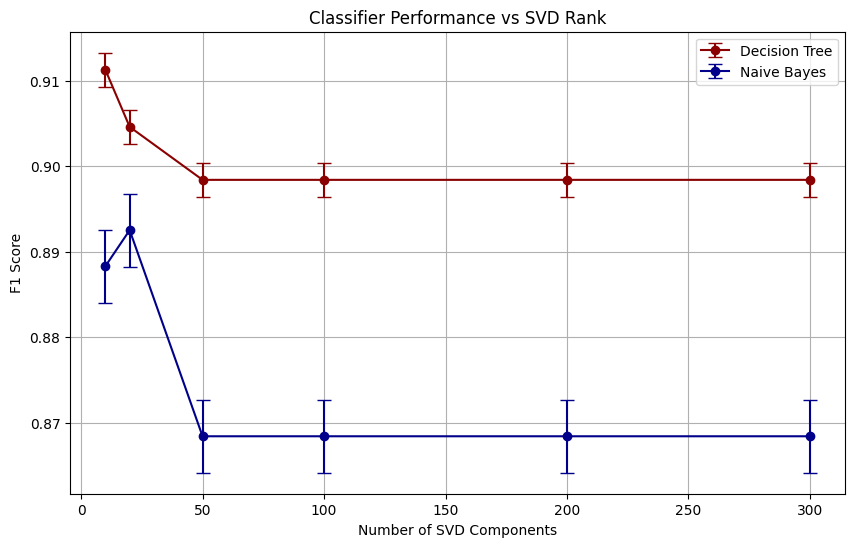

Best F1 Score for Decision Tree: 0.911 at rank 10
Best F1 Score for Naive Bayes: 0.893 at rank 20
Analysis:
Decision Trees generally perform better with lower ranks of SVD.
Naive Bayes generally performs better with lower ranks of SVD.


In [163]:
# Calculate standard deviations and display error bars for plotting
std_dev_dt = np.std(f1_scores_dt) / np.sqrt(len(f1_scores_dt))
std_dev_nb = np.std(f1_scores_nb) / np.sqrt(len(f1_scores_nb))

# Convert standard deviations into arrays for each point, if necessary
errors_dt = np.full_like(f1_scores_dt, std_dev_dt)
errors_nb = np.full_like(f1_scores_nb, std_dev_nb)

# Plotting with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(ranks, f1_scores_dt, yerr=errors_dt, label='Decision Tree', marker='o', color='darkred', linestyle='-', capsize=5)
plt.errorbar(ranks, f1_scores_nb, yerr=errors_nb, label='Naive Bayes', marker='o', color='darkblue', linestyle='-', capsize=5)

plt.xlabel('Number of SVD Components')
plt.ylabel('F1 Score')
plt.title('Classifier Performance vs SVD Rank')
plt.legend()
plt.grid(True)
plt.show()


# Output the best scores and ranks
print("Best F1 Score for Decision Tree: {:.3f} at rank {}".format(max(f1_scores_dt), ranks[np.argmax(f1_scores_dt)]))
print("Best F1 Score for Naive Bayes: {:.3f} at rank {}".format(max(f1_scores_nb), ranks[np.argmax(f1_scores_nb)]))

# Analyze results
# Identifying the rank with the best performance for Decision Tree
best_rank_dt = ranks[np.argmax(f1_scores_dt)]
best_f1_dt = max(f1_scores_dt)

# Identifying the rank with the best performance for Naive Bayes
best_rank_nb = ranks[np.argmax(f1_scores_nb)]
best_f1_nb = max(f1_scores_nb)

# Discussion and conclusions
print("Analysis:")
print(f"Decision Trees generally perform better with {'higher' if best_rank_dt == max(ranks) else 'lower'} ranks of SVD.")
print(f"Naive Bayes generally performs better with {'higher' if best_rank_nb == max(ranks) else 'lower'} ranks of SVD.")

### 3. Feature selection with randomization

### (a)
#### Randomization Function: 
A function was created to randomize each feature in the dataset individually. This function generated new datasets for each feature where the values of that specific feature were randomly permuted, preserving the order of other features.

In [99]:
def randomize_features(features):
    randomized_datasets = {}
    for column in features.columns:
        # Copy the original features to keep other features intact
        randomized_features = features.copy()
        # Randomize the specific feature
        randomized_features[column] = np.random.permutation(features[column].values)
        randomized_datasets[column] = randomized_features
    return randomized_datasets

# Generate randomized datasets for each feature
randomized_feature_datasets = randomize_features(features)


In [100]:
# Example to verify the randomization process for the first two features
print("Original Data Sample for the first feature:")
print(features.iloc[:, 0].head())
print("\nRandomized Data Sample for the first feature:")
print(randomized_feature_datasets[features.columns[0]].iloc[:, 0].head())

print("\nOriginal Data Sample for the second feature:")
print(features.iloc[:, 1].head())
print("\nRandomized Data Sample for the second feature:")
print(randomized_feature_datasets[features.columns[1]].iloc[:, 1].head())


Original Data Sample for the first feature:
0    17.99
1    20.57
2    19.69
3    11.42
4    20.29
Name: MeanRadius, dtype: float64

Randomized Data Sample for the first feature:
0    14.44
1    12.27
2    12.20
3    11.52
4    11.76
Name: MeanRadius, dtype: float64

Original Data Sample for the second feature:
0    10.38
1    17.77
2    21.25
3    20.38
4    14.34
Name: MeanTexture, dtype: float64

Randomized Data Sample for the second feature:
0    20.04
1    13.90
2    20.39
3    14.98
4    21.51
Name: MeanTexture, dtype: float64


### (b),(c),(d)

#### Evaluation:

A 20% stratified sample of the dataset was separated for feature evaluation to prevent data leakage, with the remaining 80% reserved for final model testing.

5-fold cross-validation was applied on the 20% feature selection sample to robustly assess the importance of each feature. Two models were trained for each fold: one with the original data and one with the randomized feature data.

The performance difference, measured by the F1 score, between the models trained on original data and randomized data was used to calculate the importance of each feature. A significant drop in performance indicated a high importance of the feature.

In [101]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import numpy as np

def evaluate_feature_importance(features, labels, models):
    # Stratified split into 20% for feature evaluation and 80% for final model testing
    X_selection, X_final, y_selection, y_final = train_test_split(
        features, labels, test_size=0.8, stratify=labels, random_state=42
    )

    # Reset index to ensure alignment
    X_selection.reset_index(drop=True, inplace=True)
    y_selection.reset_index(drop=True, inplace=True)
    X_final.reset_index(drop=True, inplace=True)
    y_final.reset_index(drop=True, inplace=True)

    # Use 5-fold cross-validation on the 20% sample
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    feature_importances = {name: {} for name in models.keys()}

    for feature in features.columns:
        for name, model in models.items():
            importance_scores = []

            for train_index, test_index in kf.split(X_selection, y_selection):
                X_train, X_test = X_selection.iloc[train_index], X_selection.iloc[test_index]
                y_train, y_test = y_selection.iloc[train_index], y_selection.iloc[test_index]

                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                # Randomize feature
                X_train_randomized = X_train_scaled.copy()
                np.random.shuffle(X_train_randomized[:, features.columns.get_loc(feature)])

                # Train and evaluate the model with the original data
                model.fit(X_train_scaled, y_train)
                original_f1 = f1_score(y_test, model.predict(X_test_scaled))

                # Train and evaluate the model with the randomized feature
                model.fit(X_train_randomized, y_train)
                randomized_f1 = f1_score(y_test, model.predict(X_test_scaled))

                # Calculate importance
                importance = (original_f1 - randomized_f1) / original_f1 if original_f1 > 0 else 0
                importance_scores.append(importance)

            # Average importance across folds
            feature_importances[name][feature] = np.mean(importance_scores)

    # Train final models on 80% of the data and evaluate
    final_scores = {}
    for name, model in models.items():
        scaler = StandardScaler()
        X_final_scaled = scaler.fit_transform(X_final)
        model.fit(X_final_scaled, y_final)
        final_predictions = model.predict(X_final_scaled)
        final_scores[name] = f1_score(y_final, final_predictions)

    return feature_importances, final_scores

# Initialize your models
models = {
    'Decision Tree': DecisionTreeClassifierIG(max_depth=5),
    'Naive Bayes': GaussianNaiveBayesClassifier()
}

# Evaluate feature importance and final model performance
feature_importances, final_scores = evaluate_feature_importance(features, labels, models)
print("Feature Importances:", feature_importances)
print("Final Model F1 Scores on 80% Data:", final_scores)


Feature Importances: {'Decision Tree': {'MeanRadius': -0.030476190476190507, 'MeanTexture': -0.01714285714285717, 'MeanPerimeter': 0.0, 'MeanArea': 0.0, 'MeanSmoothness': 0.048888888888888836, 'MeanCompactness': 0.0, 'MeanConcavity': 0.0, 'MeanConcavePoints': -0.004642857142857168, 'MeanSymmetry': 0.0, 'MeanFractalDimension': -0.028571428571428636, 'SERadius': -0.01538461538461539, 'SETexture': -0.022077922077922106, 'SEPerimeter': -0.023529411764705948, 'SEArea': 0.0, 'SESmoothness': 0.0, 'SECompactness': 0.002597402597402521, 'SEConcavity': 0.0, 'SEConcavePoints': 0.013333333333333346, 'SESymmetry': -0.023999999999999976, 'SEFractalDimension': 0.0, 'WorstRadius': 0.0, 'WorstTexture': -0.028571428571428636, 'WorstPerimeter': 0.0, 'WorstArea': -0.007029478458049923, 'WorstSmoothness': 0.0, 'WorstCompactness': 0.0, 'WorstConcavity': 0.0, 'WorstConcavePoints': -0.08928571428571434, 'WorstSymmetry': 0.0, 'WorstFractalDimension': 0.0}, 'Naive Bayes': {'MeanRadius': 0.0024999999999999675, '

### (e)

#### Feature Importance Analysis:

After evaluating all features, the importance scores were aggregated and features were ranked from most to least predictive based on the observed performance drop.

In [102]:
# Assuming 'feature_importances' is a dictionary containing your importance data
feature_importances_df = pd.DataFrame(feature_importances)

# Calculate signed importance for interpretive analysis
feature_importances_df['Signed Importance DT'] = feature_importances_df['Decision Tree']
feature_importances_df['Signed Importance NB'] = feature_importances_df['Naive Bayes']

# Sort the features by their signed importance for each classifier
sorted_features_dt = feature_importances_df['Signed Importance DT'].sort_values(ascending=False)
sorted_features_nb = feature_importances_df['Signed Importance NB'].sort_values(ascending=False)

# Calculate absolute importance for magnitude-based analysis
feature_importances_df['Absolute Importance DT'] = feature_importances_df['Decision Tree'].abs()
feature_importances_df['Absolute Importance NB'] = feature_importances_df['Naive Bayes'].abs()

# Sort features by absolute importance for high-level overview
sorted_abs_importances_dt = feature_importances_df['Absolute Importance DT'].sort_values(ascending=False)
sorted_abs_importances_nb = feature_importances_df['Absolute Importance NB'].sort_values(ascending=False)

# Display signed importances for detailed analytics
print("Signed Feature Importances for Decision Tree:")
print(feature_importances_df['Signed Importance DT'].sort_values(ascending=False))

print("\nSigned Feature Importances for Naive Bayes:")
print(feature_importances_df['Signed Importance NB'].sort_values(ascending=False))

Signed Feature Importances for Decision Tree:
MeanSmoothness           0.048889
SEConcavePoints          0.013333
SECompactness            0.002597
SEArea                   0.000000
WorstSymmetry            0.000000
WorstConcavity           0.000000
WorstCompactness         0.000000
WorstSmoothness          0.000000
WorstPerimeter           0.000000
WorstRadius              0.000000
SEFractalDimension       0.000000
SEConcavity              0.000000
SESmoothness             0.000000
WorstFractalDimension    0.000000
MeanSymmetry             0.000000
MeanConcavity            0.000000
MeanCompactness          0.000000
MeanArea                 0.000000
MeanPerimeter            0.000000
MeanConcavePoints       -0.004643
WorstArea               -0.007029
SERadius                -0.015385
MeanTexture             -0.017143
SETexture               -0.022078
SEPerimeter             -0.023529
SESymmetry              -0.024000
MeanFractalDimension    -0.028571
WorstTexture            -0.028571
Me

### (f) 

#### Two plots were generated: 
one showing the importance of each feature and another showing the performance of the classifiers as more top features were incrementally included

### f(i)

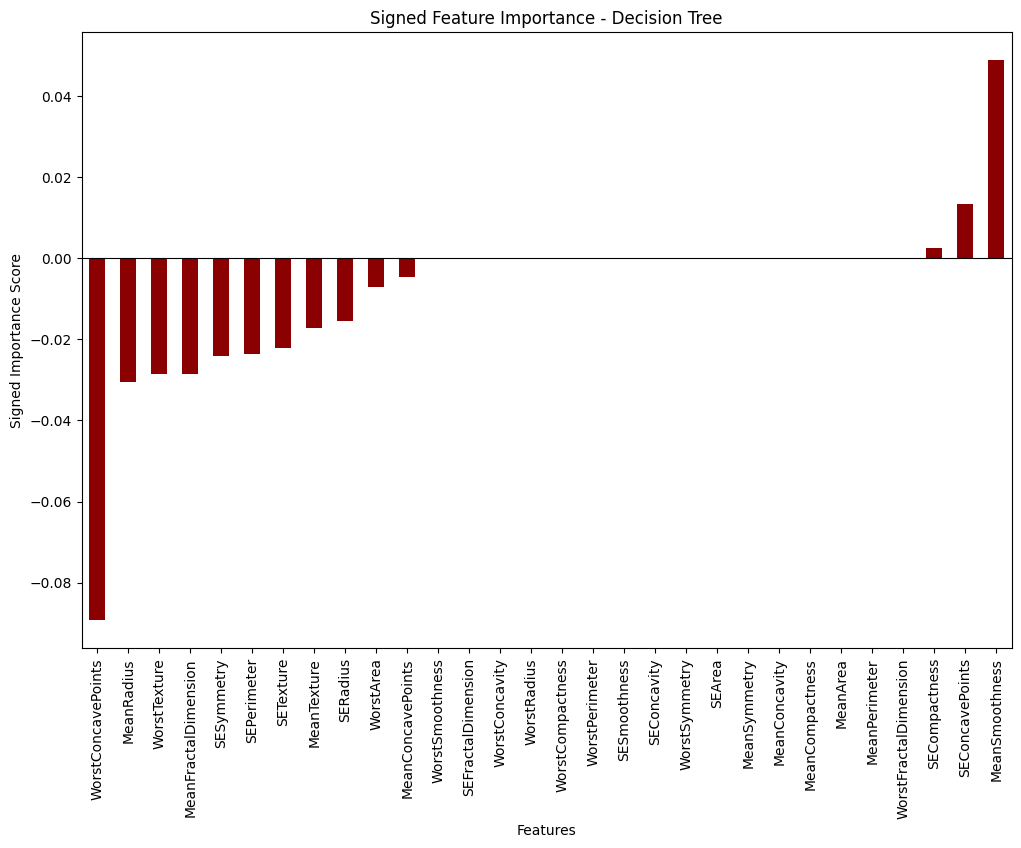

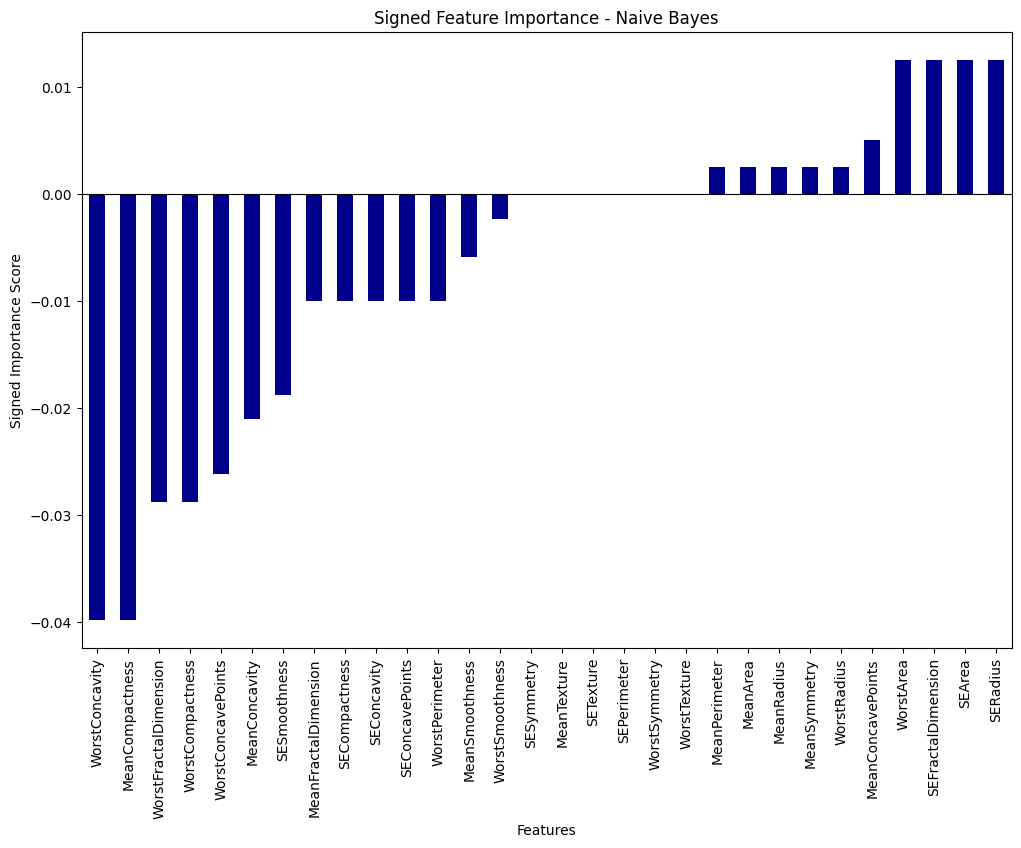

In [103]:
# Plotting signed importances for Decision Tree
plt.figure(figsize=(12, 8))
feature_importances_df['Signed Importance DT'].sort_values().plot(kind='bar', color='darkred')
plt.title('Signed Feature Importance - Decision Tree')
plt.ylabel('Signed Importance Score')
plt.xlabel('Features')
plt.axhline(0, color='black', linewidth=0.8)  # Adds a line at zero for reference
plt.show()

# Plotting signed importances for Naive Bayes
plt.figure(figsize=(12, 8))
feature_importances_df['Signed Importance NB'].sort_values().plot(kind='bar', color='darkblue')
plt.title('Signed Feature Importance - Naive Bayes')
plt.ylabel('Signed Importance Score')
plt.xlabel('Features')
plt.axhline(0, color='black', linewidth=0.8)  # Adds a line at zero for reference
plt.show()

In [110]:
def evaluate_classifier_performance(features, labels, sorted_features, classifier, n_top=10, n_splits=10):
    mean_f1_scores = []
    std_devs = []

    # Cross-validation to ensure robustness
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for i in range(1, n_top + 1):
        # Select top N features
        top_features = sorted_features.index[:i]
        X_top = features[top_features]
        
        f1_scores = []

        for train_index, test_index in kf.split(X_top, labels):
            X_train, X_test = X_top.iloc[train_index], X_top.iloc[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
            
            # Standardize the data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Initialize and train the classifier
            model = classifier()
            model.fit(X_train_scaled, y_train)
            
            # Predict and calculate F1 score
            y_pred = model.predict(X_test_scaled)
            f1_scores.append(f1_score(y_test, y_pred))
        
        # Compute the mean and standard deviation of the F1 scores
        mean_f1_scores.append(np.mean(f1_scores))
        std_devs.append(np.std(f1_scores))
    
    return mean_f1_scores, std_devs

### f(ii)

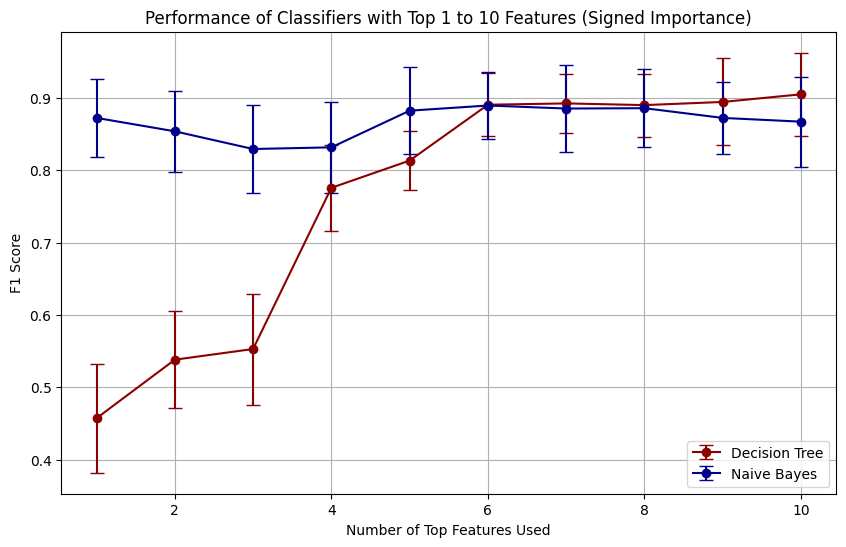

In [113]:
# Example of using the function
f1_scores_dt, std_dev_dt = evaluate_classifier_performance(features, labels, sorted_features_dt, DecisionTreeClassifierIG)
f1_scores_nb, std_dev_nb = evaluate_classifier_performance(features, labels, sorted_features_nb, GaussianNaiveBayesClassifier)

# Plotting the results with error bars
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.errorbar(range(1, 11), f1_scores_dt, yerr=std_dev_dt, label='Decision Tree', marker='o', color='darkred', linestyle='-', capsize=5)
plt.errorbar(range(1, 11), f1_scores_nb, yerr=std_dev_nb, label='Naive Bayes', marker='o', color='darkblue', linestyle='-', capsize=5)

plt.xlabel('Number of Top Features Used')
plt.ylabel('F1 Score')
plt.title('Performance of Classifiers with Top 1 to 10 Features (Signed Importance)')
plt.legend()
plt.grid(True)
plt.show()

### 4. Data augmentation using SMOTE 

#### find_k_nearest_neighbors:
Identifies k-nearest neighbors for given data points, converting data to numpy arrays if necessary.

#### smote: 
Generates synthetic samples by interpolating between minority class samples and their nearest neighbors.

#### evaluate_classifier: 
Assesses classifier performance using stratified 10-fold cross-validation, calculating the F1 score.

#### Data Preparation:

Minority class identified based on the least number of samples.

Extracted minority class data is converted to numpy arrays for processing.

#### Classifier Evaluation with SMOTE:

Iterates through combinations of k (1 and 5) and N (100%, 200%, 300% oversampling).

For each combination, synthetic samples are generated and the dataset is augmented.

Decision Tree and Gaussian Naive Bayes classifiers are evaluated.

#### Visualization:

F1 scores, along with standard deviations, are plotted against the percentage of oversampled minority samples.

Uses different markers and colors for each classifier and k value, including a legend for clarity

In [164]:
def find_k_nearest_neighbors(point, dataset, k):
    # Ensure dataset is a numpy array for distance calculation
    if isinstance(dataset, pd.DataFrame):
        dataset = dataset.values
    distances = np.linalg.norm(dataset - point, axis=1) # Calculate Euclidean distances from 'point' to all other points
    nearest_neighbors = np.argsort(distances)[1:k+1]  # Get indices of k nearest neighbors, excluding the point itself
    return nearest_neighbors

In [165]:
def smote(minority_data, N, k):
    synthetic_samples = []
    for i in range(len(minority_data)):
        nn_indices = find_k_nearest_neighbors(minority_data[i], minority_data, k)  # Find nearest neighbors for each sample
        for _ in range(N): # Generate N synthetic samples
            nn = np.random.choice(nn_indices)  # Randomly pick a neighbor
            diff = minority_data[nn] - minority_data[i] # Calculate the difference vector between the neighbor and the sample
            gap = np.random.rand() # Generate a random scaling factor
            synthetic_sample = minority_data[i] + gap * diff  # Create synthetic sample by interpolating
            synthetic_samples.append(synthetic_sample)
    return np.array(synthetic_samples) # Return synthetic samples as a numpy array

In [166]:
def evaluate_classifier(clf, X, y):
    scores = []
    for train_index, test_index in skf.split(X, y): # Split data into 10 folds
        X_train, X_test = X[train_index], X[test_index] # Extract train and test data
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)  # Train the classifier on the training set
        y_pred = clf.predict(X_test) # Predict labels for the test set
        score = f1_score(y_test, y_pred) # Calculate the F1 score for the predictions
        scores.append(score) # Append the score to the list
    return np.mean(scores), np.std(scores) # Return the mean and standard deviation of scores

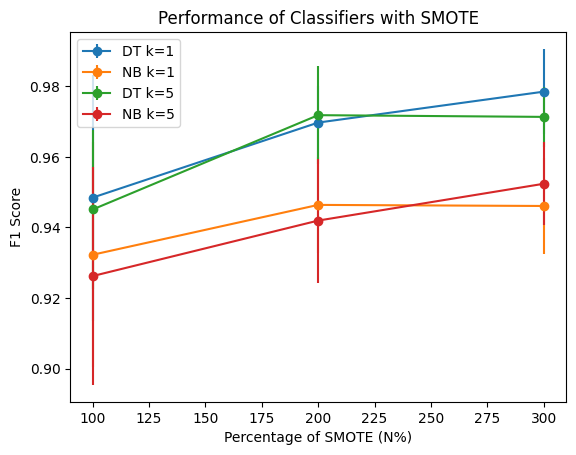

In [167]:
from collections import Counter

ks = [1, 5] # Different values for k-nearest neighbors
Ns = [1, 2, 3]  # Corresponding to 100%, 200%, and 300% oversampling

class_counts = Counter(labels) # Count the occurrences of each class
minority_class = min(class_counts, key=class_counts.get)

# Ensure minority_data is a NumPy array for distance calculations
minority_data = features[labels == minority_class] # Identify the minority class
minority_data = minority_data.values if isinstance(minority_data, pd.DataFrame) else minority_data


fig, ax = plt.subplots()

# Evaluate each classifier with different SMOTE parameters
for k in ks:
    scores_dt = []
    errors_dt = []
    scores_nb = []
    errors_nb = []
    for N in Ns:
        synthetic_samples = smote(minority_data, N, k) # Generate synthetic samples using SMOTE
        synthetic_labels = np.array([minority_class] * len(synthetic_samples)) # Create labels for synthetic samples
        X_train_augmented = np.vstack([features, synthetic_samples]) # Augment the feature set with synthetic samples
        y_train_augmented = np.hstack([labels, synthetic_labels]) # Augment the label set accordingly

        dt_clf = DecisionTreeClassifierIG()
        nb_clf = GaussianNaiveBayesClassifier()

        mean_dt, std_dt = evaluate_classifier(dt_clf, X_train_augmented, y_train_augmented) # Evaluate Decision Tree classifier
        mean_nb, std_nb = evaluate_classifier(nb_clf, X_train_augmented, y_train_augmented) # Evaluate Naive Bayes classifier

        scores_dt.append(mean_dt)
        errors_dt.append(std_dt)
        scores_nb.append(mean_nb)
        errors_nb.append(std_nb)

    # Plotting the results with error bars
    N_percentages = [n * 100 for n in Ns]  # Convert to percentage
    ax.errorbar(N_percentages, scores_dt, yerr=errors_dt, label=f'DT k={k}', marker='o')
    ax.errorbar(N_percentages, scores_nb, yerr=errors_nb, label=f'NB k={k}', marker='o')

ax.set_title('Performance of Classifiers with SMOTE')
ax.set_xlabel('Percentage of SMOTE (N%)')
ax.set_ylabel('F1 Score')
ax.legend()
plt.show()